In [2179]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Necessary Import**

In [2180]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision import models, datasets
from torch.utils.data import Dataset , DataLoader, random_split, WeightedRandomSampler, ConcatDataset

torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.cuda.set_device(0)

**EDA**

In [2181]:
path = '../input/deep-learning-for-msc-coursework-2021/'

df = pd.read_csv(path + 'train.csv')

df.Id = df.Id.astype(str)

Displaying the count of each type

In [2182]:
df.Type.value_counts()

Immune        729
Connective    726
Cancer        546
Normal        189
Name: Type, dtype: int64

[]

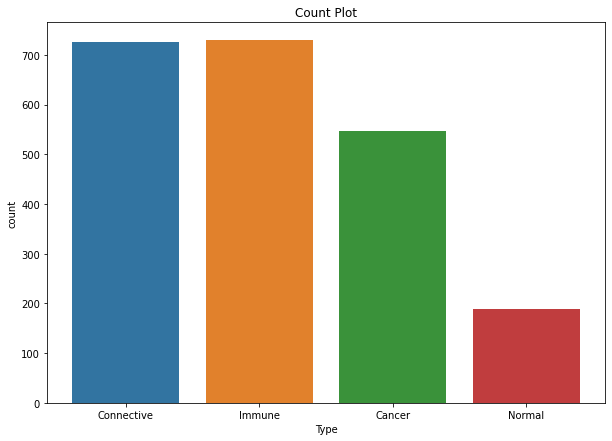

In [2183]:
fig=plt.figure(figsize=(10,7))
sns.countplot(data=df,x="Type")
plt.title('Count Plot')
plt.plot()

This is used to Map the label to type in dataframe

In [2184]:
i=0
target = {}
for type_ in df.Type.unique():
    target[type_] = i 
    i+=1

target

{'Connective': 0, 'Immune': 1, 'Cancer': 2, 'Normal': 3}

In [2185]:
df['label'] = df['Type'].map(target)
df['img_path'] = (path + 'train/train/' + (df['Id']) +  '.png' )
df

,Id,Type,label,img_path
0,1,Connective,0,../input/deep-learning-for-msc-coursework-2021...
1,2,Connective,0,../input/deep-learning-for-msc-coursework-2021...
2,3,Connective,0,../input/deep-learning-for-msc-coursework-2021...
3,4,Connective,0,../input/deep-learning-for-msc-coursework-2021...
4,5,Connective,0,../input/deep-learning-for-msc-coursework-2021...
...,...,...,...,...
2185,2186,Immune,1,../input/deep-learning-for-msc-coursework-2021...
2186,2187,Cancer,2,../input/deep-learning-for-msc-coursework-2021...
2187,2188,Connective,0,../input/deep-learning-for-msc-coursework-2021...
2188,2189,Connective,0,../input/deep-learning-for-msc-coursework-2021...


**Visualising the Data**

In [2186]:
def visualizer(label_of_class):
    b = df[df['Type'] == label_of_class].iloc[:,3].sample(30)
    #Picks a sample of 4 images randomly
    
    rows = 3
    cols = 5
    axes=[] 
    plt.figure(figsize=(10,10))
    for a in range(rows*cols):
        plt.suptitle( label_of_class, fontsize=16) #Sets the main title for the class
        plt.subplot(rows,cols,a+1)    # the number of images in the grid is 5*3 (15)
        plt.imshow(imread(b.iloc[a])) 
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()   
    plt.show()

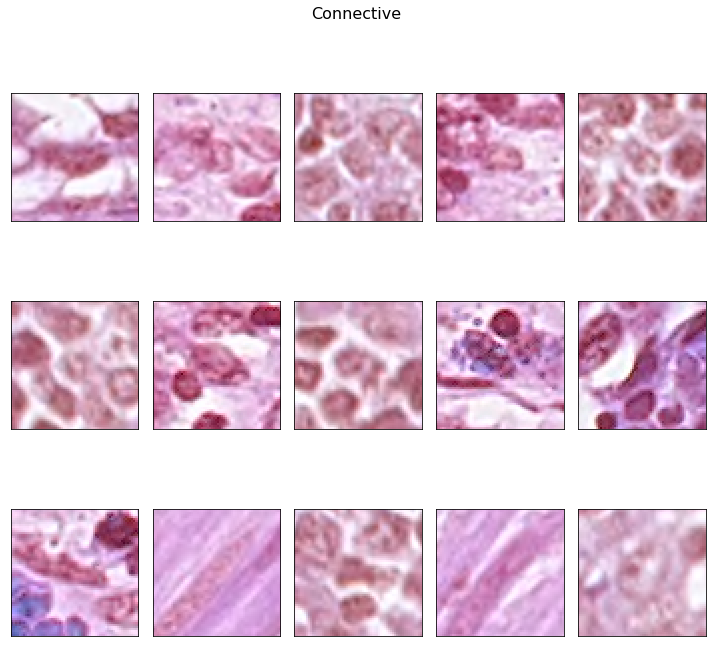

--------------------------------------------------------------------------------


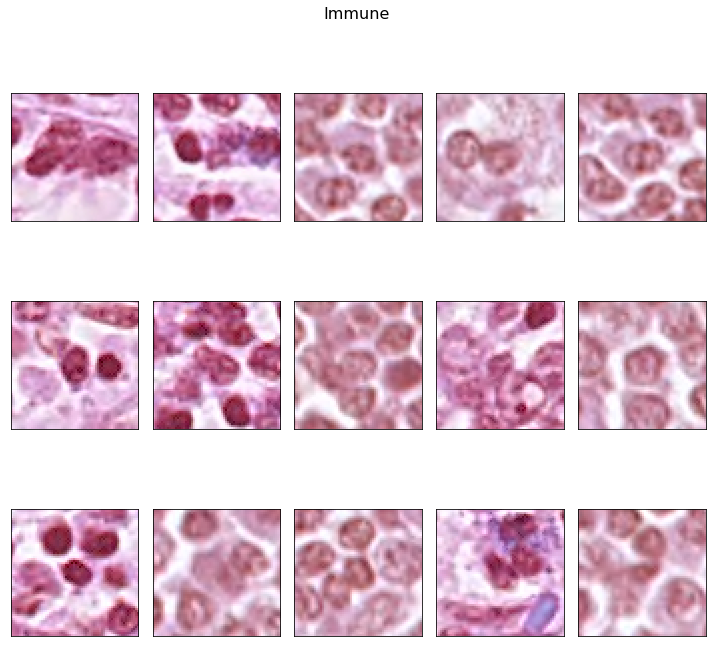

--------------------------------------------------------------------------------


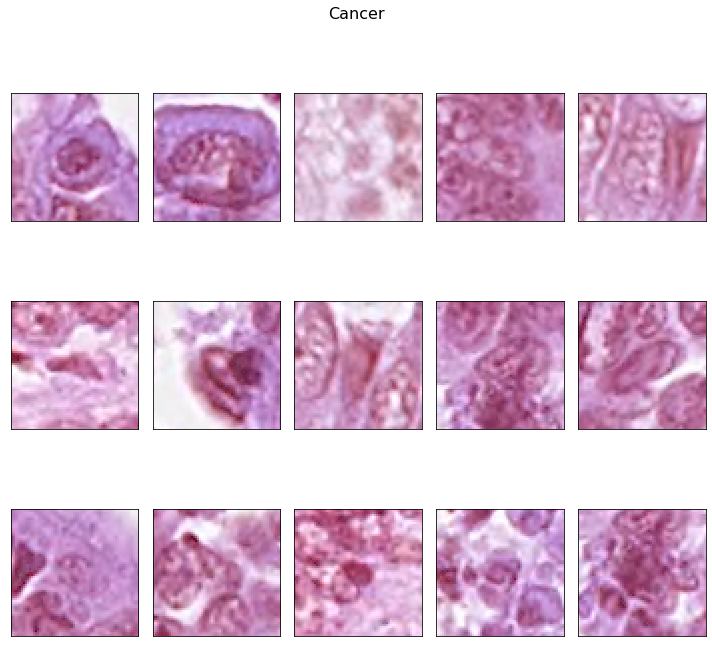

--------------------------------------------------------------------------------


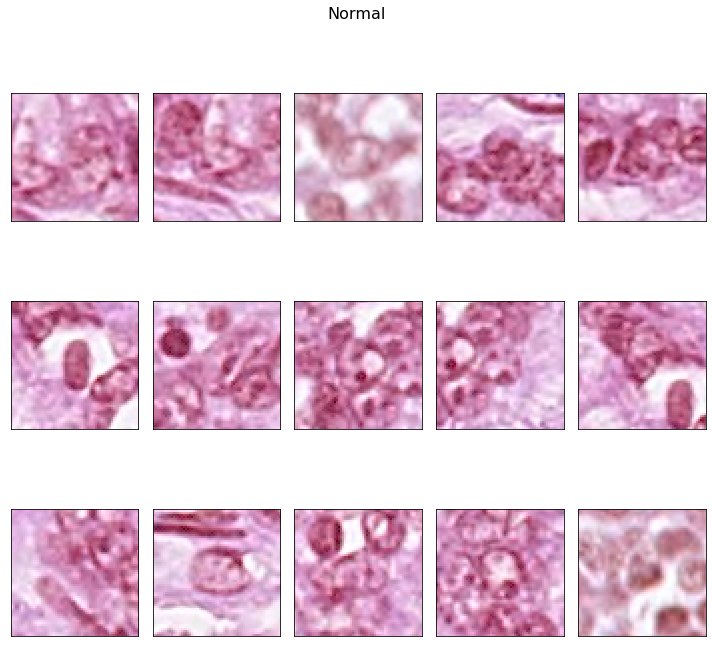

--------------------------------------------------------------------------------


In [2187]:
for  i in df.Type.unique():
    visualizer(i)
    print('-' * 80)

**Basic Transformation / Data Augmentation**

In [2188]:
# Several studies shows that these values works well for image classification
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.RandomVerticalFlip(p=0.7),
                                      transforms.ColorJitter(brightness=(0.7,1),contrast=(0.5,1),saturation=(0.8,1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std),  
                                      ])

test_transform =  transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std),  
                                      ])

#copy_of_dataset_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),
                                      #transforms.RandomVerticalFlip(p=1),
                                      #transforms.ColorJitter(brightness=(0.7,1),contrast=(0.5,1),saturation=(0.8,1)),
                                      #transforms.ToTensor(),
                                     #transforms.Normalize(mean=mean,std=std),  
                                      #])

**Custom Dataset**


* This class takes in a dataframe and returns a dataset, as we cant use Image loader here because of the structure of the data

* This also takes in those transforamtion and applies it

In [2189]:
class CustomDataset(Dataset):
 
    def __init__(self, data_frame, transform = None):
 
        self.to_tensor = transforms.ToTensor()
        self.df = data_frame
        self.image_arr = np.asarray(self.df['img_path'])
        self.label_arr = np.asarray(self.df['Type'])
        self.target_array = torch.from_numpy(np.asarray(self.df['label']))
        self.transform = transform

    def __len__(self):
        
        #This returns the lenght of the dataset
        
        return len(self.df)
 
    def __getitem__(self,index):
 
        #Retrieving the image path and opening the image in PIL format
        
        single_image_name = self.image_arr[index]
        img_as_img = Image.open(single_image_name)
        img_as_img = img_as_img.convert('RGB')
        
        #Label of the image
        single_image_label = self.target_array[index]
              
        #Random Transformation
        if self.transform is not None:

            image = self.transform(img_as_img) 
        else:
            image = self.to_tensor(img_as_img)     

        return (image.cuda() , single_image_label.cuda())

I initally planned to make a copy of the original dataset and make different transformations to it and concatenate with the initial dataset. But due to poor performance of it, droppen it.


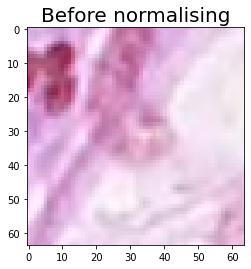

In [2190]:
dataset = CustomDataset(data_frame=df,transform= None)


#
#second_dataset = CustomDataset(data_frame=df.sample(frac = 0.8),transform= copy_of_dataset_transform)
#dataset = ConcatDataset([first_dataset, second_dataset])


for item,j in dataset:
    break
plt.title('Before normalising', fontsize=20)
plt.imshow(  item.cpu().permute(1, 2, 0)  )

**Train and Test Split**

In [2191]:
train_percent = int(len(dataset)/100 * 95)
test_percent = len(dataset)- train_percent


train_dataset , test_dataset = random_split(dataset,(train_percent,test_percent))

**Over Sampling**

* This medthod can be used to balance the dataset by sampling it.
* Class weights are the weights for each type of data in our df. In index 3, we see  3.0 because we have very less samples of normal one

In [2192]:

class_weights = [1.1,1.0,1.3,3.0]
sample_weights = [0] * len(train_dataset)

for idx, (data,label) in enumerate(train_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

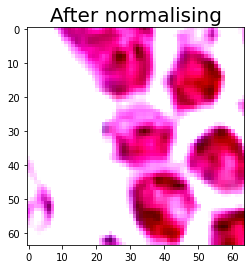

In [2193]:
#Applying the transformations only to train dataset and normalising the test dataset

train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Iters the dataset once and plots the first image, just to check  
for item,j in train_dataset:
    break
plt.title('After normalising', fontsize=20)
plt.imshow(  item.cpu().permute(1, 2, 0)  )

**DataLoader**

In [2194]:
train_loader = DataLoader(dataset = train_dataset, batch_size= 64, sampler = None, shuffle = True)
test_loader = DataLoader(dataset = test_dataset)


**Class Counter**
* This is used to determine how many classes are there in our train dataset.

In [2195]:
train_classes = [np.array(label.cpu().numpy()).astype(np.int32).flatten() for _, label in train_loader]

from collections import Counter
counter = []
for i in range(len(train_classes)):
    #np.append(np.array(counter),np.array(train_classes[i]))
    counter = counter + list(train_classes[i])
print(len(counter))    
Counter(counter)

2080


Counter({2: 517, 0: 697, 3: 177, 1: 689})

**Model**

In [2196]:
class CNN(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3,512,3,1)
        self.conv2 = nn.Conv2d(512,512,3,1)
        self.conv3 = nn.Conv2d(512,256,3,1)
        self.fc1 = nn.Linear(6*6*256,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,4)
        self.drop = nn.Dropout(0.5)
        
    def forward(self,X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = self.drop(X)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = self.drop(X)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
       # print(X.shape)
        X = X.view(-1,6*6*256)
        X = F.relu(self.fc1(X))
        X = self.drop(X)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X


* Here we can use weights to optimiser to balance the class, predicting the class wrong with high weights leads to high error.

In [2197]:
model = CNN()
#weight = torch.tensor([1.0,1.0,1.3,4.5])
criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.2,1.04,1.3,2])).cuda()#Class weighting
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)

#Learning rate scheduler
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, verbose = True)

Switching the model to GPU

In [2198]:
model = model.cuda()
next(model.parameters()).is_cuda
torch.cuda.empty_cache()

**Helper Functions**


In [2199]:
def validate(y_pred, y_true):
    predicted = torch.max(y_pred.data, 1)[1]
    num_correct = (predicted == y_true).sum()
    return num_correct

def print_status(epoch,train_loss, test_loss, train_acc, test_acc):
    print(f'\n\nEpoch: {epoch+1} \nTraining\nLoss: {train_loss: .4f}\tAccuracy: {train_acc: .4f}\nTesting\nLoss: {test_loss: .4f}\tAccuracy: {test_acc: .4f}')

**Training the Model**

In [2200]:
import time
start_time = time.time()

epochs = 50

train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []

best_loss = 10

for epoch in range(epochs):
    train_acc = 0
    test_acc = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        
        #Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)

        #Calculating accuracy
        train_acc += validate(y_pred, y_train)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss.append(loss)  
    train_accuracy.append(train_acc/train_percent)
        
    #Saving the best model
    if loss < best_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_loss = loss
        print('\nModel saved\n')
        
    #Validate the test data    
    with torch.no_grad():
        
        model.eval()
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            test_acc += validate(y_val, y_test)
        model.train()  
        
     #Loss of test data   
    val_loss = criterion(y_val,y_test) 
    test_loss.append(val_loss)
    test_accuracy.append(test_acc/test_percent)
    print_status(epoch, train_loss[epoch],test_loss[epoch],train_acc/train_percent,test_acc/test_percent)

total_time = time.time() - start_time 
print('\nn Total time: ', total_time/60)


Model saved



Epoch: 1 
Training
Loss:  1.4971	Accuracy:  0.3716
Testing
Loss:  1.3841	Accuracy:  0.4818

Model saved



Epoch: 2 
Training
Loss:  1.1443	Accuracy:  0.5274
Testing
Loss:  1.2271	Accuracy:  0.6000

Model saved



Epoch: 3 
Training
Loss:  0.7789	Accuracy:  0.6187
Testing
Loss:  1.3083	Accuracy:  0.6727


Epoch: 4 
Training
Loss:  0.8244	Accuracy:  0.6904
Testing
Loss:  1.0576	Accuracy:  0.6727


Epoch: 5 
Training
Loss:  0.9892	Accuracy:  0.7053
Testing
Loss:  1.8927	Accuracy:  0.7091

Model saved



Epoch: 6 
Training
Loss:  0.6926	Accuracy:  0.7188
Testing
Loss:  1.5614	Accuracy:  0.7636


Epoch: 7 
Training
Loss:  0.8840	Accuracy:  0.7192
Testing
Loss:  1.2508	Accuracy:  0.7273


Epoch: 8 
Training
Loss:  0.8113	Accuracy:  0.7423
Testing
Loss:  0.7694	Accuracy:  0.6818


Epoch: 9 
Training
Loss:  0.6995	Accuracy:  0.7428
Testing
Loss:  1.5412	Accuracy:  0.7273


Epoch: 10 
Training
Loss:  1.0890	Accuracy:  0.7288
Testing
Loss:  0.5318	Accuracy:  0.7091

Model saved


**Plotting the Loss Curve**

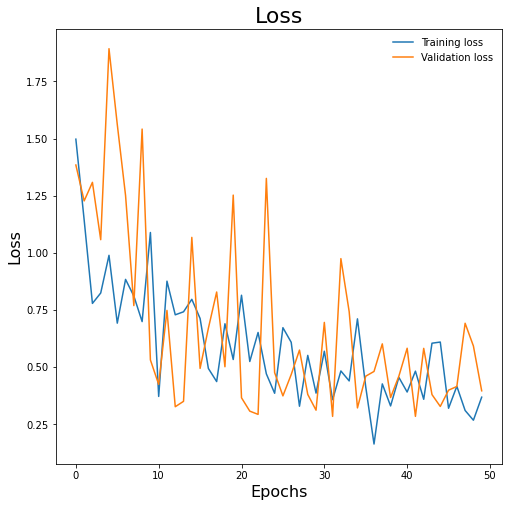

In [2201]:
plt.figure(figsize=(8,8))
plt.title('Loss', fontsize=22)
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(frameon=False)
plt.show()

**Plotting the Accuracy Curve**

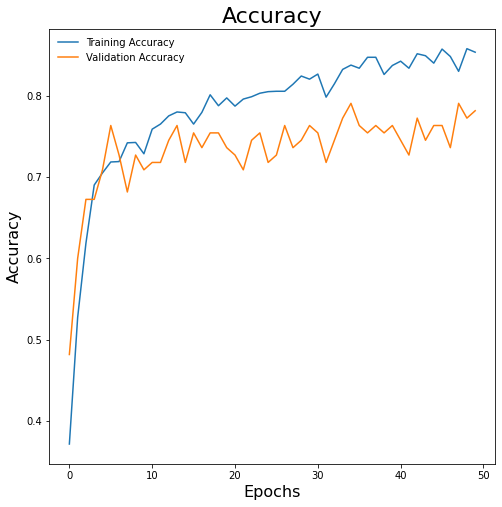

In [2202]:
plt.figure(figsize=(8,8))
plt.title('Accuracy',fontsize=22)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(frameon=False)
plt.show()

**Evaluating the test  Data**

In [2203]:
test_loader = DataLoader(dataset = test_dataset)
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    prediction = []
    y_true = []
    for X_test, y_test in test_loader:
        
        y_val = model(X_test)        
        predicted = torch.max(y_val.data, 1)[1]
        prediction.append(predicted.view(-1,1).cpu().numpy())
        y_true.append(y_test.cpu().numpy())        

model.train()

CNN(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

**Confusion Matrix**

In [2204]:
y_true = np.array(y_true).astype(np.int32).flatten()
prediction = np.array(prediction).astype(np.int32).flatten()


confusion_matrix(np.array(y_true), np.array(prediction), labels = [0,1,2,3])

array([[18,  9,  2,  0],
       [ 5, 35,  0,  0],
       [ 4,  0, 20,  5],
       [ 0,  2,  0, 10]])

**Classification Report**

In [2205]:
from sklearn.metrics import classification_report

print(classification_report(y_true, prediction, target_names=['Connective','Immune','Cancer','Normal']))

              precision    recall  f1-score   support

  Connective       0.67      0.62      0.64        29
      Immune       0.76      0.88      0.81        40
      Cancer       0.91      0.69      0.78        29
      Normal       0.67      0.83      0.74        12

    accuracy                           0.75       110
   macro avg       0.75      0.75      0.75       110
weighted avg       0.76      0.75      0.75       110



**Submission**

In [2206]:
# Normalising the data on which the model has been trained on
sub_dataset = datasets.ImageFolder(path + 'test/', transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ]))


sub_dataloader = torch.utils.data.DataLoader(sub_dataset)

#Prediction
model.eval()
with torch.no_grad():
    prediction = []
    for image, label in sub_dataloader:
        output = model(image.cuda())
        prediction.append(torch.argmax(output,1))

In [2207]:
submission_df = pd.read_csv( path + 'example.csv')
submission_df.drop(columns='Type', inplace=True)
submission_df['Type'] = np.array(prediction)

In [2208]:
#Mapping the label names for numerical targets
def remap(x):
    if x == 0 :
        return 'Connective'
    if x == 1:
        return 'Immune'
    if x == 2:
        return 'Cancer'
    if x == 3:
        return 'Normal'

submission_df['Type'] = submission_df['Type'].apply(remap)

submission_df.to_csv('submission1.csv',index=False)
